In [1]:
import numpy as np
import matplotlib.pyplot as plt

<h1>Geometry</h1>

All the particles will evolve inside a 2D rectangle with one missing wall. This rectangle has a length $L$ and a height $h$.

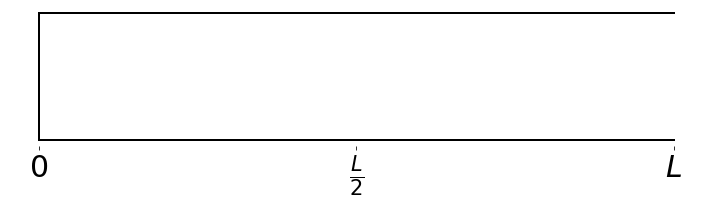

In [2]:
L = 10
h = 2

def create_base_plot():
    fig,ax1 = plt.subplots(1,1,figsize=(10,3))
    ax1.set_aspect('equal')
    ax1.plot([0,L],[0, 0], color='black', linewidth=2)
    ax1.plot([0,L],[h, h], color='black', linewidth=2)
    ax1.plot([0,0],[0, h], color='black', linewidth=2)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_xticks([0, int(L/2), L])
    ax1.set_xticklabels(['$0$', '$\\frac{L}{2}$', '$L$'], fontsize=30)

    plt.tight_layout()
    return fig, ax1

fig, ax1 = create_base_plot()
plt.show()

<h1>Particles</h1>

Now let's add some particles at random locations but limited to the far left end of the box. These particles are point-like and don't interact with other particles but do experience elastic collisions with the walls of the box and obstacles that will be introduced later. Also all particles have a random initial velocity with an $x$ component pointing in the direction of the exit or $x = L$. You might recall these set of assumptions from the derivation of the ideal gas in Thermodynamics.

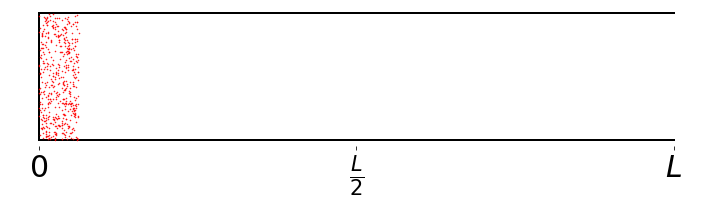

In [3]:
N = 500 # Number of particles
particles = []

def create_simple_particle(ax=None):
    x = np.random.random()*L/16
    y = np.random.random()*h   
    vx = np.random.random()*L/8
    return {
        'x'      : x,
        'y'      : y,
        'vx0'    : vx,
        'vx'     : vx,
        'vy'     : (np.random.random()*L/8)*2 - 1,
        'marker' : (ax.plot(x,y, marker='o',
                                 markersize=0.5,
                                 markerfacecolor='red',
                                 markeredgecolor='red') 
                    if ax != None 
                    else None)
    }

fig, ax1 = create_base_plot()
for n in range(N):
    particles.append(create_simple_particle(ax1))

plt.show()

<h1>Setting up the physical rules</h1>

In the previous section we listed assumptions about the particles but said little about its equations of motion. If the only external force is one due to gravitational acceleration in the $x$ direction we do a newtonian balance of forces for each component as follows 
$$
\begin{aligned}
\sum F_x &= ma_x\\
      mg &= ma_x\\
      g &= \frac{d v_x}{dt}\\
      v_x &= gt + v_{x0}
\end{aligned}
$$

Similarly for the $y$ direction we obtain
$$
\begin{aligned}
    \frac{d v_y}{dt} &= 0\\
    v_y &= v_{y0}
\end{aligned}
$$

Where $v_{x0}$ and $v_{y0}$ are the random speeds assigned by the python method <b>create_particle</b>. Let's animate the particles for the purposes of demonstration and quality check. When attempting to derive Darcy's law, we'll be ignoring the animation to focus more on the statistical aspects of running many simulations.

<IPython.core.display.Javascript object>


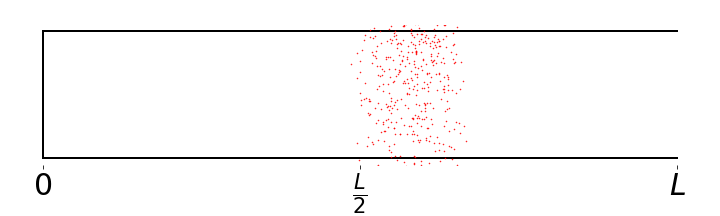

In [9]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

N = 500
dt = 0.01

fig, ax1 = create_base_plot()
particles = []
for n in range(N):
    particles.append(create_simple_particle(ax1))

def update(frame):
    for p in particles:
        p['vx'] = 9.81*frame*dt + p['vx0']
        p['x'] = p['x'] + p['vx']*dt
        p['y'] = p['y'] + p['vy']*dt
        p['marker'][0].set_data(p['x'], p['y'])
        
    return map(lambda p: p['marker'][0], particles)

animation = FuncAnimation(fig, update, 
                          frames=100, 
                          blit=True, 
                          interval=50, 
                          repeat=False)
plt.show()


<h1>Obstacles and porous medium</h1>

Before we add collisions, let's take a moment to introduce more complicated geometries. The end goal here is to test if we can numerically derive Darcy's law. This involves a pressure differential across a porous material and a fluid contained inside it. To simulate pores we're going to add wall-like obstacles to our box so that the particles can collide with them and take a more complicated route from $x = 0$ to $x = L$.

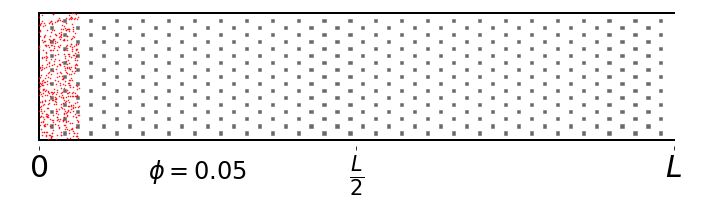

In [5]:
%matplotlib inline
from matplotlib.patches import Rectangle

N = 500
dt = 0.01

def add_obstacles(ax, rows, cols):
    l = 0.05
    all_obstacles = []
    col_domain = np.linspace(0, L, cols)
    row_domain, dr = np.linspace(0, h, rows, retstep=True)
    for k1,i in enumerate(col_domain):
        for k2,j in enumerate(row_domain):
            is_even_col = (k1 % 2 == 0)
            x1 = i
            y1 = j + (dr/2 if is_even_col else 0)
            if (0 < y1 < h) and (0 < y1+l < h) and (0 < x1 < L) and (0 < x1+l < L):
                all_obstacles.append(
                    {
                        'x1' : x1 - l/2,
                        'y1' : y1 - l/2,
                        'x2' : x1 + l/2,
                        'y2' : y1 + l/2
                })
                ax.add_patch(Rectangle((x1 - l/2, y1 - l/2), l, l,
                                       lw=0.5,
                                       edgecolor='dimgrey',
                                       facecolor='dimgrey',
                                       fill=True))
    return all_obstacles

def create_particle(ax, obstacles):
    def is_particle_on_obstacle(x,y):
        for o in obstacles:
            if (o['x1'] < x < o['x2']) and (o['y1'] < y < o['y2']):
                return True
        return False

    x = np.random.random()*L/16
    y = np.random.random()*h    
    while is_particle_on_obstacle(x,y):
        x = np.random.random()*L/16
        y = np.random.random()*h
    
    vx = np.random.random()*L/8
    return {
        'x'      : x,
        'y'      : y,
        'vx0'    : vx,
        'vx'     : vx,
        'vy'     : (np.random.random()*L/8)*2 - 1,
        'marker' : (ax.plot(x,y, marker='o',
                                 markersize=0.5,
                                 markerfacecolor='red',
                                 markeredgecolor='red') 
                    if ax != None 
                    else None)
    }

fig, ax1 = create_base_plot()
all_obstacles = add_obstacles(ax1, 10, 50)
particles = []
for n in range(N):
    particles.append(create_particle(ax1, all_obstacles))

if len(all_obstacles) > 0:
    obs_area = (all_obstacles[0]['x2'] - all_obstacles[0]['x1'])**2
    phi = round(len(all_obstacles)*obs_area/(L*h), 2)    
else:
    phi = 0
ax1.text(L/4, -0.6, f'$\\phi = {phi}$', fontsize=24, horizontalalignment='center')
    
plt.show()

We defined $\phi$ as the ratio of obstacle area to total area for reference. Now for the movement part. What's an efficient way of updating each particle's velocity at every time step? Here's one way to solve this:

 - Choose a particle and draw a circle of radius $|\vec{v}|dt$ around it
 - Filter all obstacles by whether or not they fall inside this circle
 - Sort filtered obstacles by their distance from the center of the circle
 - Compute time-to-collision and choose the one with the smallest time
 - Update position to collision point
 - Apply reflection / elastic collision
 - Repeat until the particle has moved for $dt$ seconds
 
Let's illustrate this algorithm with a chart:

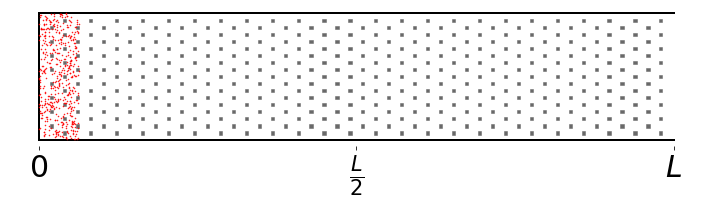

In [6]:
fig, ax1 = create_base_plot()
all_obstacles = add_obstacles(ax1, 10, 50)
particles = []
for n in range(N):
    particles.append(create_particle(ax1, all_obstacles))
    
# Choose random particle and draw circle of interest
n = np.random.randint(len(particles))


plt.show()